In [1]:
# Basic Vocab

# Observations/Instances/Samples
#   In machine learning, an observation refers to a single instance of data in a dataset.
#   Each observation consists of several features and, in supervised learning, a target label.
#   A sample is a subset of observations/instances in a data set.
# From: https://deepchecks.com/glossary/observation-ml/

# Target Label/Variable/Class
#   A target is a dataset variable to be predicted by an ML model.
#   This is the variable that describes the outcome of the process.
#   Broadly speaking, the terms label, class, and target may be used interchangeably.
# From https://toloka.ai/blog/machine-learning-labels-and-features/

# Supervised vs Unsupervised Learning:
#   This notebook is an exercise in supervised learning to create a classifier to
#   determine if a sentence contains gender bias.
# Further reading: https://www.ibm.com/think/topics/supervised-vs-unsupervised-learning

# Paper discussing types of gender bias in language: https://arxiv.org/pdf/2201.08675

In [2]:
import pandas as pd

# Open 'societal_bias_data.tsv' to inspect the data set.
# The columns should be self-explanatory, with the exception of 'label':
# - 0 indicates a lack of societal gender bias.
# - 1 indicates a presence of societal gender bias.

# Import training data. "df" is short here for "data frame" (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).
df = pd.read_csv('aggregate_data.tsv', sep='\t')

In [3]:
# Use this block to add your own data to the model!

# Write test sentences.
new_data = [[-1, 'Women make better cooks than men.', 1],
            [-1, 'Men are equal to women.', 0]]

# Create the pandas DataFrame and vectorize data.
temp_df = pd.DataFrame(new_data, columns=['id', 'sentence', 'label'])

# To add new data to the TRAINING data, uncomment this line.
# This adds our new data to the END of the data set.
df = pd.concat([df, temp_df])
# To add new data to the TEST data, uncomment this line.
# This adds our new data to the BEGINNING of the data set.
# df = pd.concat([temp_df, df])

In [4]:
# Run this to see basic metadata describing the structure of our raw training data.
# You can see the column labels and the number of observations.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1693 entries, 0 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1693 non-null   int64 
 1   sentence  1693 non-null   object
 2   label     1693 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 52.9+ KB


In [5]:
# Run this for some basic statistics on our raw training data.
# None of the data in the 'id' colum is particularly useful.
# From the 'label' column, we can look at the mean to see percentage of data labeled as 0 vs 1.
df.describe()

,id,label
count,1693.000000,1693.000000
mean,844.327820,0.520378
std,488.490288,0.499732
min,-1.000000,0.000000
25%,422.000000,0.000000
50%,844.000000,1.000000
75%,1267.000000,1.000000
max,1690.000000,1.000000


<Axes: ylabel='Frequency'>

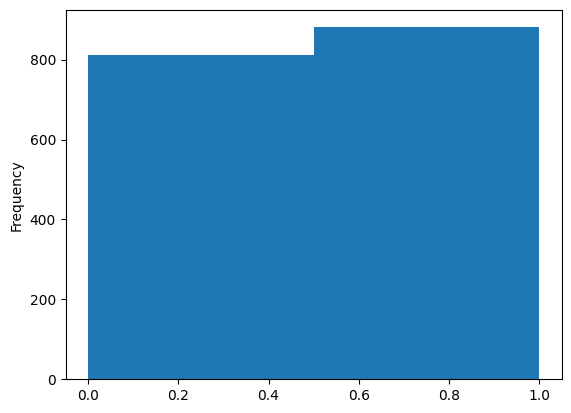

In [6]:
# Plot the histogram of the class column.
# This can help us visualize the distribution of our observations in terms of gender bias.
df['label'].plot(bins=2,kind = 'hist')

In [7]:
sentences_no_bias = df[df['label']==0]
sentences_bias = df[df['label']==1]

# Uncomment these (ideally one at a time) to inspect the data.
# print(sentences_no_bias)
# print(sentences_bias)

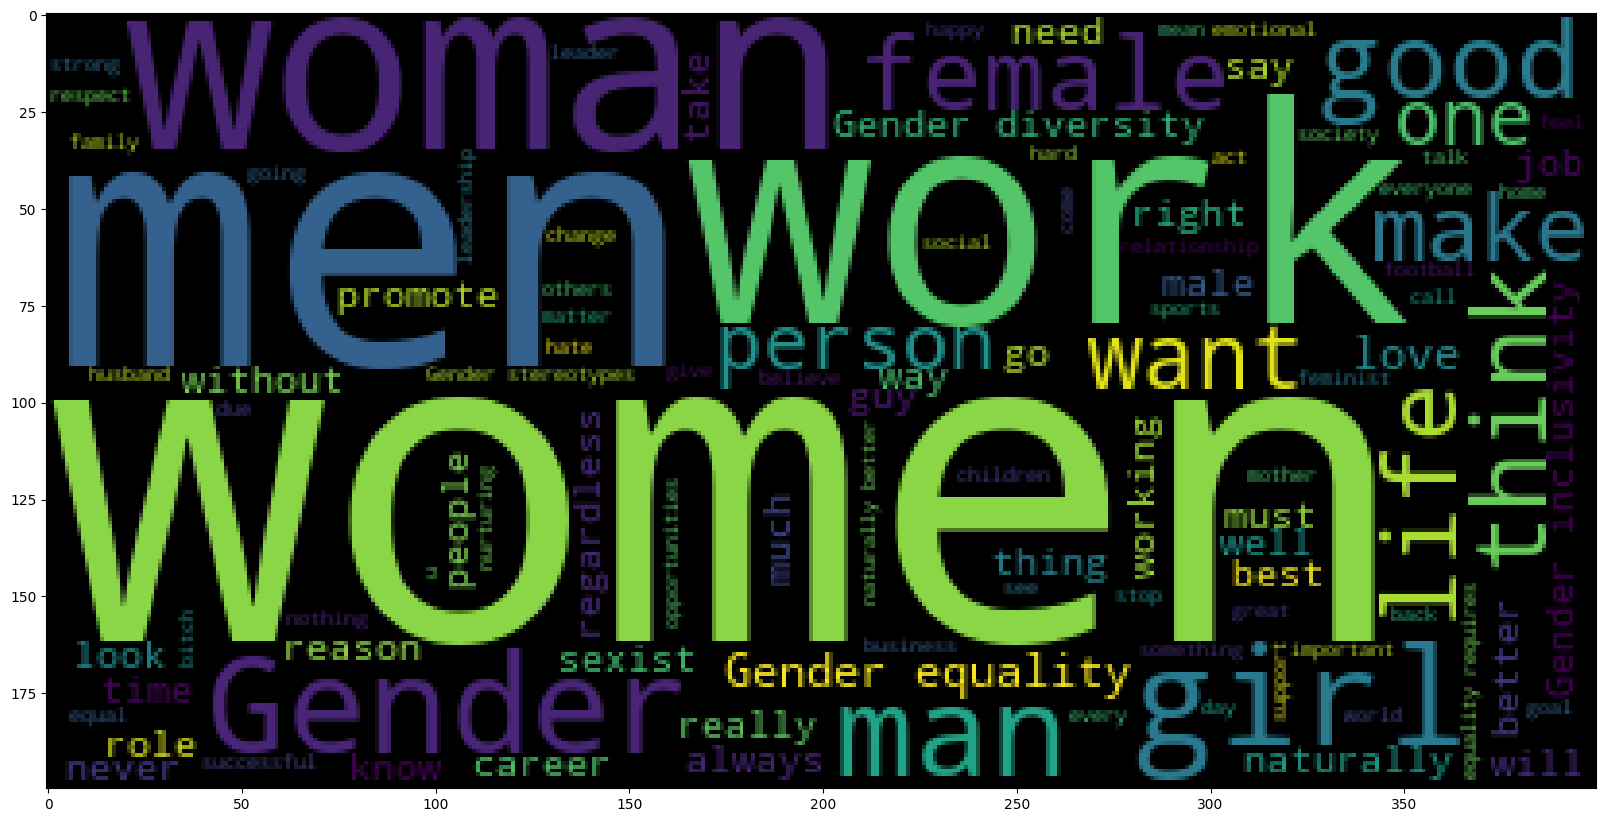

In [8]:
# This block takes a quick detour to generate a word cloud of our data set.
import matplotlib.pyplot as plt
from wordcloud import WordCloud

sentences = df['sentence'].tolist()
combined = " ".join(sentences)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(combined))

In [9]:
# Natural language toolkit
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Tuning a model via pre-processing steps in a pipeline.
#
# It is important to keep a CLEAN dataset.
# Here, we can use our common sense to realize that the "ID" column in our data and punctuation are not relevant
# in predicting whether a statement has gender bias or not.
# Removing extraneous data will strengthen the predictive capability of a model.
# Let's think about this in a more practical example:
# When we determine what color a cup is, does the time of day matter? Or the volume on the TV in the background?
# We want to only focus on the cup and lighting.

# Drop unnecessary column; the 'id' serves no purpose in terms of identifying gender bias.
df = df.drop(['id'], axis=1)

# Re-running this block may show an error, as we can't remove the 'id' column more than once.
# If it's gone, it's gone!

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# What else can we do to "pre-process" our data set?
import string
import re

def preprocess_text(text):
    # Replace hyphens with whitespace
    text = text.replace('-', ' ')
    
    # Remove all '#' symbols
    text = text.replace('#', '')
    
    # Replace Twitter usernames (e.g., @username) with the word "username"
    text = re.sub(r'@\w+', 'username', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Lowercase all words
    text = text.lower()
    
    return text

# This defines a function that will remove "stop words" from our sentences.
def removeStopWords(msg, stopwordsList):
    return [word for word in msg.split() if word.lower() not in stopwordsList]

In [11]:
# Uncomment the following line to look at a common stop word list.
# print(stopwords.words('english'))

# What do you notice about the list of stop words? They seem to include some gendered terms,
# which we very much care about. What do you think should/shouldn't be a stopword?
# You can try processing the data with base stop words and compare it to a smaller subset.
# How do the results change?
new_stopwords = set(stopwords.words('english')) -\
{'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself'}
# Uncomment this to look at the modified list of stopwords.
# print(new_stopwords)

In [12]:
# Define pipeline to handle our pre-processing routine.
def pipeline(msg):
    base_preprocessed = preprocess_text(msg)
    # result = removeStopWords(noPunct, stopwords.words('english'))
    result = removeStopWords(base_preprocessed, new_stopwords)
    return result

df_clean = df['sentence'].apply(pipeline)

In [13]:
# Let's examine a single instance and what its pre-processed form looks like.
print(df['sentence'][5])
print(df_clean[5])

# Should we remove 'both' from the stop word list?

Both men and women can be leaders in their communities.
['men', 'women', 'leaders', 'communities']


In [14]:
# For the purposes of this exercise, this code should be run but not deeply investigated.

# Tokenization (Count Vectoring)
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# min/max_df
# dtype: type of the matrix returned; really only needs to be large if an example has potential to have a VERY high count of a feature (word).
vectorizer = CountVectorizer(analyzer = pipeline, dtype = np.uint8)
input_countVectorizer = vectorizer.fit_transform(df['sentence'])
X = pd.DataFrame(input_countVectorizer.toarray())
Y = df['label']

In [15]:
# Naive Bayesian Classifiers
# Prior probability (total in dataset)
# Defined as # of sa in class / total number of examples
# Likelihood (proximity feature-wise to classified data points)
# Bayes' Theorem combines both: Posterior Prob = Prior Prob * Likelihood. Higher prob = decision.
# P(Outcome | Sample Features)  = P(Outcome) * P(Sample Features | Outcome) / P(Sample Features)
# Further reading: https://en.wikipedia.org/wiki/Naive_Bayes_classifier

In [16]:
from sklearn.model_selection import train_test_split
# Due to container resource restraints, test_size at a sufficiently small value will cause the kernel to crash.
# test_size determines the split of our data used to train vs test our model.
# Ex. test_size = 0.1 means 90% of the data will be used to train our model and 10% will be used to test it.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)


In [17]:
from sklearn.naive_bayes import MultinomialNB

# Train our model.
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, Y_train)

MultinomialNB()

In [18]:
# Confusion Matrix (https://www.sciencedirect.com/topics/engineering/confusion-matrix)
#                          True Class
#       |       |        0         |         1         |
# -----------------------------------------------------|
# Predi |   0   |     No error     |    Type 1 error   |
# cted  |   1   |   Type 2 error   |     No error      |
# Class |

<Axes: >

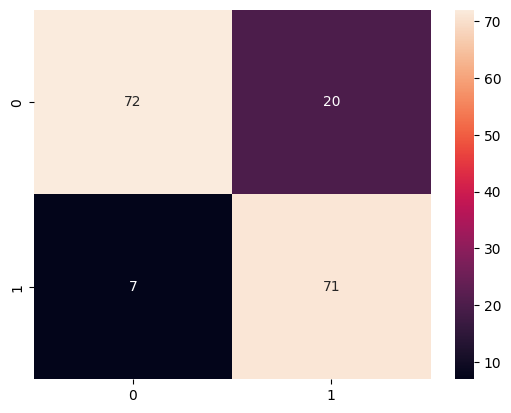

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict_test)
sns.heatmap(cm, annot=True)

In [20]:
print(classification_report(Y_test, Y_predict_test))
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
# The precision is intuitively the ability of the classifier not to label a negative sample as positive.

# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives.
# The recall is intuitively the ability of the classifier to find all the positive samples.

# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall,
# where an F-beta score reaches its best value at 1 and worst score at 0.
# The F-beta score weights recall more than precision by a factor of beta.
# beta == 1.0 means recall and precision are equally important. Beta defaults to 1.0 here.
# Note that in binary classification, recall of the positive class is also known as “sensitivity”;
# recall of the negative class is “specificity”.

              precision    recall  f1-score   support

           0       0.91      0.78      0.84        92
           1       0.78      0.91      0.84        78

    accuracy                           0.84       170
   macro avg       0.85      0.85      0.84       170
weighted avg       0.85      0.84      0.84       170



In [21]:
# This is a handy block for investigating TEST data and the associated predictions.

# Define how many sentences we want to look at.
# NOTE: This CANNOT be greater than the test data size shown below. You have been warned...
desired_inspection_window = len(temp_df)

print("Test data size: " + str(len(Y_predict_test)))
print("Desired inspection window size: " + str(desired_inspection_window))

print("\nDF Inspection window:")
inspected_df = df[len(df['sentence']) - desired_inspection_window:]
# Using DataFrame.insert() to add a column using predicted data
inspected_df.insert(2, "predicted-label", Y_predict_test[len(Y_predict_test) - desired_inspection_window], False)
print(inspected_df.to_string())


Test data size: 170
Desired inspection window size: 2

DF Inspection window:
                            sentence  label  predicted-label
0  Women make better cooks than men.      1                0
1            Men are equal to women.      0                0
